In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [ ]:
# Load the MNIST dataset and preprocess it
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Set the latent dimension (number of latent variables)
latent_dim = 2

In [ ]:
# Encoder model
def build_encoder():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)

    # Mean and log variance layers for the latent space
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    # Reparameterization trick
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name='encoder')


In [ ]:
# Decoder model
def build_decoder():
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name='decoder')

In [ ]:

# Build the encoder and decoder
encoder = build_encoder()
decoder = build_decoder()

In [ ]:
# VAE model
inputs = layers.Input(shape=(28, 28, 1))
z_mean, z_log_var, z = encoder(inputs)
reconstructed = decoder(z)
vae = Model(inputs, reconstructed, name='vae')


In [ ]:
# Define the VAE loss
def vae_loss(inputs, reconstructed):
    # Access z_mean and z_log_var from the encoder output
    z_mean, z_log_var, _ = encoder(inputs)  # _ for the unused z

    # Flatten the tensors within the loss function
    reconstruction_loss = tf.keras.losses.binary_crossentropy(
        K.flatten(inputs), K.flatten(reconstructed)
    )
    reconstruction_loss *= 28 * 28

    # Use Keras backend operations for z_mean and z_log_var
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

# Compile the model with the custom loss function
vae.compile(optimizer='adam', loss=vae_loss)

In [ ]:
# Train the VAE
vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 267.5749 - val_loss: 194.6279
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 192.5164 - val_loss: 187.4141
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 187.1433 - val_loss: 183.4673
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 180.9108 - val_loss: 166.8663
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 166.1504 - val_loss: 163.1806
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 161.9915 - val_loss: 159.3273
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 159.3663 - val_loss: 157.3380
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 157.5246 - val_loss: 157.0306
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 156.8468 - val_loss: 155.5640
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 156.0397 - val_loss: 154.6136
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 154.7690 - val_loss: 154.5683
Epoch 

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


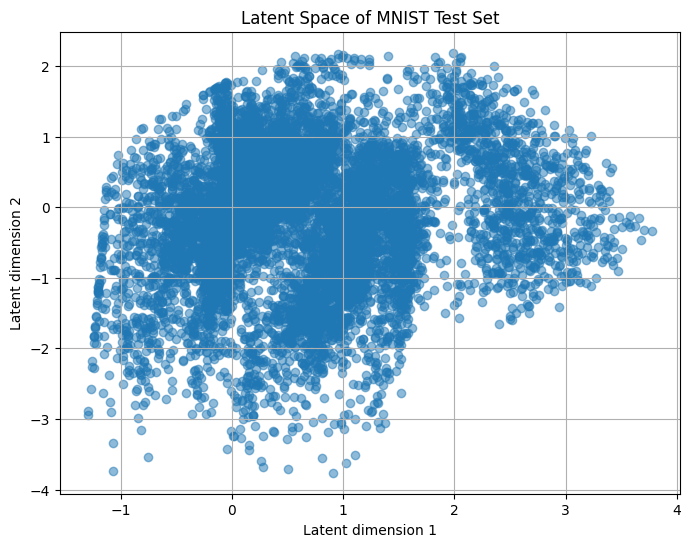

In [ ]:

# Function to plot the latent space representation of test images
def plot_latent_space(encoder, x_test, n=1000):
    z_mean, _, _ = encoder.predict(x_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.title("Latent Space of MNIST Test Set")
    plt.grid(True)
    plt.show()

plot_latent_space(encoder, x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

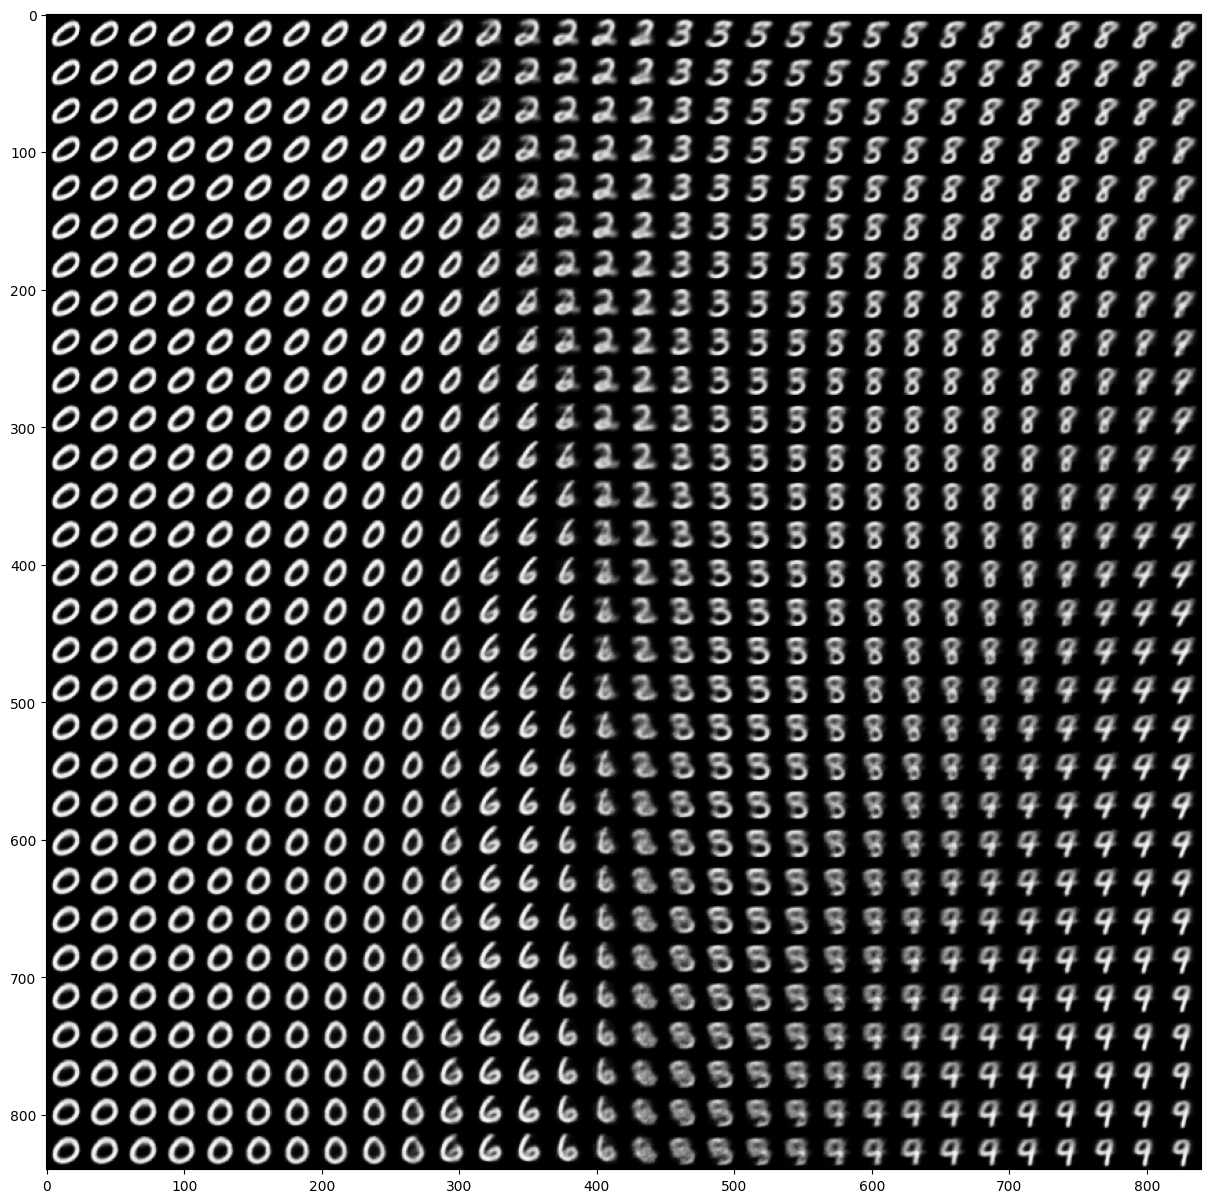

In [ ]:
# Function to plot images generated from the latent space
def plot_latent_space(encoder, decoder, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# Plot the generated images from the latent space
plot_latent_space(encoder, decoder)